In [74]:
import pandas as pd

df_offers = pd.read_excel("./data/WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

   past_peak  
0      False  
1      False  
2       True  
3       True  
4       True

## Only 32 types of offers
顧客有被特定offer吸引進而產生transactions就會形成下面的一個record

In [75]:
df_transactions = pd.read_excel("./data/WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

customer_name  offer_id  n
0         Smith         2  1
1         Smith        24  1
2       Johnson        17  1
3       Johnson        24  1
4       Johnson        26  1

## 產生pivot table

In [76]:
# join the offers and transactions table
df = pd.merge(df_offers, df_transactions)
# create a "pivot table" which will give us the number of times each customer responded to a given offer
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
# a little tidying up. fill NA values with 0 and make the index into a column
matrix = matrix.fillna(0).reset_index()
# save a list of the 0/1 columns. we'll use these a bit later
x_cols = matrix.columns[1:]

In [77]:
matrix.head()

offer_id customer_name    1    2    3    4    5    6    7    8    9 ...    23  \
0                Adams  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
1                Allen  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0 ...   0.0   
2             Anderson  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
3               Bailey  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   
4                Baker  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 ...   0.0   

offer_id   24   25   26   27   28   29   30   31   32  
0         0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  
1         0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
2         1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
3         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 33 columns]

In [78]:
x_cols

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='object', name='offer_id')

## 利用過去各個顧客對offer的反應做Clustering

In [80]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=5)
# slice matrix so we only include the 0/1 indicator columns in the clustering
matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[1:]])
matrix.cluster.value_counts()

3    36
2    22
0    16
4    15
1    11
Name: cluster, dtype: int64

## 使用PCA將所有offer的indicator variables轉成2維, 然後跟cluster結果合併

In [81]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customer_clusters = matrix[['customer_name', 'cluster', 'x', 'y']]
customer_clusters.head()

offer_id customer_name  cluster         x         y
0                Adams        2  1.007580  0.108215
1                Allen        3 -0.287539  0.044715
2             Anderson        4 -0.392032  1.038391
3               Bailey        2  0.699477 -0.022542
4                Baker        3  0.088183 -0.471695

## 結合所有資料

In [82]:
df = pd.merge(df_transactions, customer_clusters)
df = pd.merge(df_offers, df)
df.head()

offer_id campaign varietal  min_qty  discount  origin  past_peak  \
0         1  January   Malbec       72        56  France      False   
1         1  January   Malbec       72        56  France      False   
2         1  January   Malbec       72        56  France      False   
3         1  January   Malbec       72        56  France      False   
4         1  January   Malbec       72        56  France      False   

  customer_name  n  cluster         x         y  
0        Thomas  1        1 -1.041879  0.122314  
1       Jackson  1        1 -0.839578 -0.328823  
2      Mitchell  1        3 -0.342938  0.302186  
3      Peterson  1        4 -0.797379  0.475995  
4          Wood  1        1 -0.551215 -0.395670

## Visualization

In [83]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

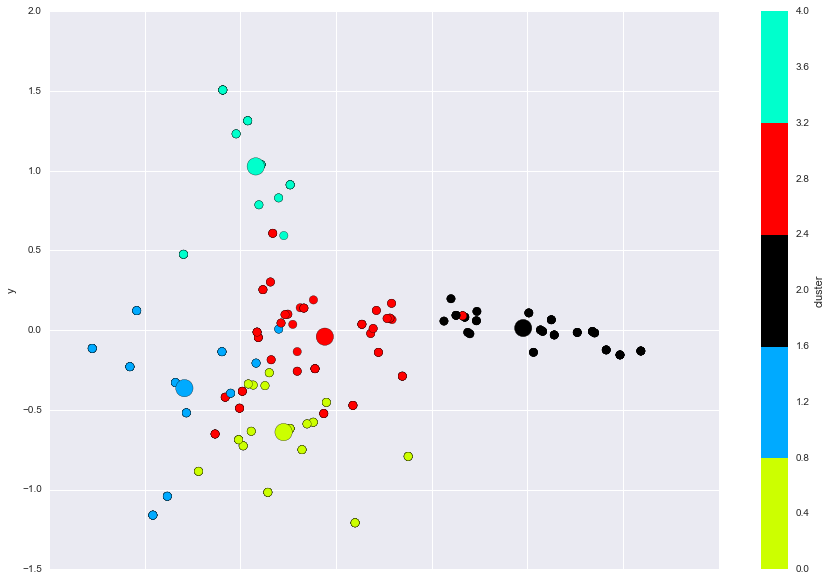

In [92]:
from matplotlib.colors import ListedColormap
color_array = ['#CCFF00', '#00AAFF', '#000000', '#FF0000', '#00FFCC']
cmap_bold = ListedColormap(color_array)


cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))


df.plot('x', 'y', kind='scatter', c='cluster', cmap=cmap_bold,  s=70, figsize=(15, 10));
plt.scatter(cluster_centers['x'], cluster_centers['y'], c=cluster_centers['cluster'], cmap=cmap_bold, s=300);

In [89]:
df['cluster'].value_counts()

3    91
2    67
0    67
1    59
4    40
Name: cluster, dtype: int64

In [95]:
df['is_2'] = df.cluster==2
df.groupby("is_2").varietal.value_counts()

is_2   varietal          
False  Champagne             81
       Pinot Noir            44
       Cabernet Sauvignon    32
       Prosecco              31
       Espumante             20
       Malbec                16
       Chardonnay            15
       Merlot                14
       Pinot Grigio           4
True   Espumante             20
       Malbec                16
       Pinot Grigio          13
       Prosecco              12
       Merlot                 6
Name: varietal, dtype: int64

In [96]:
df.groupby("is_2")[['min_qty', 'discount']].mean()

min_qty   discount
is_2                       
False  72.070039  60.638132
True    6.000000  55.044776